## Entanglement surface code

In this notebook, we will reproduce the experimental results of [Satzinger et al, Science 2021](https://www.science.org/doi/10.1126/science.abi8378) showing the realization of a surface code, and the demonstration of presence of long-range entanglement via the measurement of the topological entanglement entropy

In [22]:
using Revise
using RandomMeas
using ProgressMeter

A surface code of distance $d$ is made of $N=d^2$ qubits placed in a square lattice

In [23]:
d = 5#Code distance
N  = d^2; #number of physical qubits

# function to connect lattice coordinates to an index
# such that x = (i-1)%d+1 y = (i-1)÷d+1
g(x,y) = x+(y-1)*d 

g (generic function with 1 method)

The surface code is defined by a set of Plaquette $B_p=X_{i_1}X_{i_2}X_{i_3}X_{i_4}$ and $A_s=Z_{j_1}Z_{j_2}Z_{j_3}X_{j_4}$ operators (see graphics below). For the X plaquettes, we define the plaquette operators X_stab by the position of their lower left qubit, while X_stab_qubits stores all involved qubits.

In [24]:
#Positions of the X stabilizers
X_stab = Vector{Vector{Int}}()
X_stab_qubits = Vector{Vector{Int}}()
for y in 0:d
    start = (y+1)%2+1
    for x in start:2:d-1
        push!(X_stab,[x,y])
        qubits = Vector{Int}()
        for inx in 0:1
            for iny in 0:1
                xq = x+inx
                yq = y+iny
                if yq>0 && yq<d+1
                    push!(qubits,g(xq,yq))
                end
            end
        end
        push!(X_stab_qubits,qubits)
    end
end

We do the same for the $Z$ plaquettes.

In [25]:
Z_stab_qubits = Vector{Vector{Int}}()
Z_stab = Vector{Vector{Int}}()
for x in 0:d
    start = (x)%2+1
    for y in start:2:d-1
        push!(Z_stab,[x,y])
        qubits = Vector{Int}()
        for inx in 0:1
            for iny in 0:1
                xq = x+inx
                yq = y+iny
                if xq>0 && xq<d+1
                    push!(qubits,g(xq,yq))
                end
            end
        end
        push!(Z_stab_qubits,qubits)
    end
end

A graphical represenation of the qubits (red dots) and plaquette operators helps

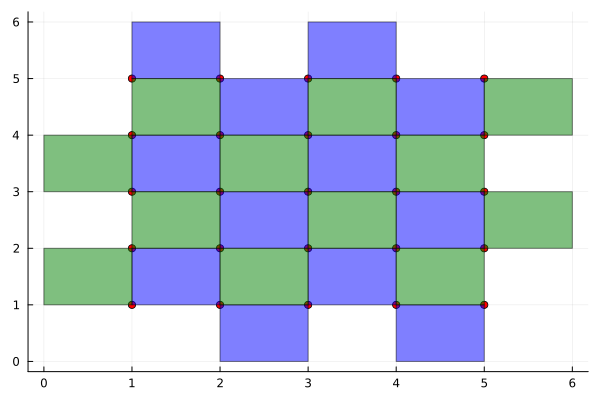

In [26]:
using Plots
plt = plot(leg=false)
scatter([X_stab[1][1]],[X_stab[1][2]])
for i in 1:N
    scatter!(plt,[(i-1)%d+1],[(i-1)÷d+1],mc=:red)
end
for X in X_stab
    plot!(plt,Shape(X[1] .+ [0,1,1,0], X[2] .+ [0,0,1,1]), fc=:blue, opacity=.5)
end
for Z in Z_stab
    plot!(plt,Shape(Z[1] .+ [0,1,1,0], Z[2] .+ [0,0,1,1]), fc=:green, opacity=.5)
end
display(plt)

To build the surface code numerically with ITensor, we initialize the state in the Z basis, and apply the projectors $1+B_p$ sequentially (in the Google experiment, one had to realize effectively this projection by a carefully designed gate sequence)

We obtain a surface with a bond dimension which scales as $2^d$ (The MPS representation provides an efficient compression along one spatial dimension)

In [27]:
ξ = siteinds("Qubit", N)
states = ["Up" for n in 1:N]
ψ = MPS(ξ,states);
@showprogress dt=1 for qubits in X_stab_qubits
    ampo = AutoMPO()
    ampo .+= "Id", qubits[1]
    if length(qubits)==2
        ampo .+= "X", qubits[1],"X",qubits[2]
    else
        ampo .+= "X", qubits[1],"X",qubits[2],"X",qubits[3],"X",qubits[4]
    end
    Proj = MPO(ampo,ξ)
    ψ = apply(Proj,ψ) # Application of the projector and normalization
    normalize!(ψ)
end
println("Surface code built with distance ", d," and bond dimension ",maxlinkdim(ψ))

Surface code built with distance 5 and bond dimension 8


If our logical state is successfully created, all plaquette operators should have expectation value $+1$. This can be checked by sampling two bitstrings, one in the $Z$ basis, one in the $X$ basis. Note: Here we are simply interested in checking that we successfully created the state. For doing quantum error correction, one would use ancilla qubits to perform these measurements. 

In [28]:
orthogonalize!(ψ,1)
normalize!(ψ)
data_Z = ITensorMPS.sample(ψ)
expect_Z = Int[]
for qubits in Z_stab_qubits
    push!(expect_Z,(-1)^sum(data_Z[qubits] .-1))
end
println("number of Z errors ",sum(1. .-expect_Z)/2)

number of Z errors 0.0


In [29]:
gates = [op("H",ξt) for ξt in ξ]
ψx = apply(gates,ψ)
orthogonalize!(ψx,1)
normalize!(ψx)
data_X = ITensorMPS.sample(ψx)
expect_X = Int[]
for qubits in X_stab_qubits
    push!(expect_X,(-1)^sum(data_X[qubits] .-1))
end
println("number of X errors ",sum(1. .-expect_Z)/2)

number of X errors 0.0


The topological entanglement entropy can be defined by considering three neighboring partitions $A|B|C$
$S_{top}=S_A+S_B+S_C=S_{AB}-S_{BC}-S_{AC}+S_{ABC}$
where each entropy can be extracted from randomized measurements.

In [30]:

A = sort([g(3,3),g(3,4),g(3,5)])
B = sort([g(4,3),g(5,3),g(5,4)])
C = sort([g(4,4),g(4,5),g(5,5)])
AB  = sort([A;B])
BC  = sort([B;C])
AC  = sort([A;C])
ABC  = sort([A;B;C])
subsystems = [A,B,C,AB,AC,BC,ABC]
nb_subsystems = length(subsystems);


We compute the exact values of the entropy of the subsystem.  Notice that all entropies are integer because we are dealing with a Clifford state with flat entanglement spectrum.

In [47]:
S_e = zeros(nb_subsystems)

ρ = outer(ψ',ψ)
for ib in 1:nb_subsystems
    ρP = reduce_to_subsystem(ρ, subsystems[ib])
    S_e[ib] = -log2(get_trace_moment(ρP,2))
end

@show round.(S_e, digits=2)

round.(S_e, digits = 2) = [3.0, 3.0, 3.0, 6.0, 4.0, 3.0, 3.0]


7-element Vector{Float64}:
 3.0
 3.0
 3.0
 6.0
 4.0
 3.0
 3.0

We can now simulate the local measurements. We can do this on the entire system and the select the subsystem of interest in the post-processing. This follows the "measure first, ask questions later." paradigm. Due to the large system size, it can however take a long time to classical simulate the measurements. We provide a faster method, based on selecting the subystem of interest first, below.

In [70]:
NU = 200
NM = 1000

measurement_group = MeasurementGroup(ψ,NU,NM;mode="MPS/MPO",progress_bar=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


In [71]:
S = zeros(nb_subsystems)
for ib in 1:nb_subsystems

    measurement_group_subsystem = reduce_to_subsystem(measurement_group, subsystems[ib])
    S[ib] = -log2(get_purity(measurement_group_subsystem))

    println("Subsystem: ", subsystems[ib], "| Entropy estimated = " , round.(S[ib],digits=3) , "| Entropy exact = " , round.(S_e[ib],digits=3))

end

Subsystem: [13, 18, 23]| Entropy estimated = 3.006| Entropy exact = 3.0
Subsystem: [14, 15, 20]| Entropy estimated = 2.997| Entropy exact = 3.0
Subsystem: [19, 24, 25]| Entropy estimated = 2.992| Entropy exact = 3.0
Subsystem: [13, 14, 15, 18, 20, 23]| Entropy estimated = 6.167| Entropy exact = 6.0
Subsystem: [13, 18, 19, 23, 24, 25]| Entropy estimated = 4.11| Entropy exact = 4.0
Subsystem: [14, 15, 19, 20, 24, 25]| Entropy estimated = 2.882| Entropy exact = 3.0
Subsystem: [13, 14, 15, 18, 19, 20, 23, 24, 25]| Entropy estimated = 3.056| Entropy exact = 3.0


In [72]:
println("Expected topological entanglement entropy ", S_e[1]+S_e[2]+S_e[3]-S_e[4]-S_e[5]-S_e[6]+S_e[7])
println("Measured topological entanglement entropy ", S[1]+S[2]+S[3]-S[4]-S[5]-S[6]+S[7])

Expected topological entanglement entropy -1.000000000000011
Measured topological entanglement entropy -1.108388929608525


Here, we first select the subystem of interest, i.e. the subsystem which contains all the qubits which are in one of the partitions. Then, we only simulate randomized measuerments on this subsystem containing 9 qubits. Now, we can employ the "dense" mode which is much faster. Compared to NU=200 above, we now can do NU=2000 in approximately the same computational time.

In [73]:
ITensors.disable_warn_order()
NU = 2000

measurement_subsystem = sort(unique(vcat(subsystems...))) # This contains exactly those qubits which are
ρ_subsystem = reduce_to_subsystem(ρ,measurement_subsystem)
measurement_group_subsystem = MeasurementGroup(ρ_subsystem,NU,NM;mode="dense",progress_bar=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


In [74]:
S_subsystem = zeros(nb_subsystems)
for ib in 1:nb_subsystems
    index_subsystem = findall(x -> x in subsystems[ib], measurement_subsystem)
    S_subsystem[ib] = -log2(get_purity(measurement_group_subsystem,index_subsystem))
    println("Partition: ", subsystems[ib], "| Entropy estimated = " , round.(S_subsystem[ib],digits=3) , "| Entropy exact = " , round.(S_e[ib],digits=3))
end

Partition: [13, 18, 23]| Entropy estimated = 3.001| Entropy exact = 3.0
Partition: [14, 15, 20]| Entropy estimated = 3.001| Entropy exact = 3.0
Partition: [19, 24, 25]| Entropy estimated = 2.999| Entropy exact = 3.0
Partition: [13, 14, 15, 18, 20, 23]| Entropy estimated = 6.07| Entropy exact = 6.0
Partition: [13, 18, 19, 23, 24, 25]| Entropy estimated = 4.033| Entropy exact = 4.0
Partition: [14, 15, 19, 20, 24, 25]| Entropy estimated = 2.898| Entropy exact = 3.0
Partition: [13, 14, 15, 18, 19, 20, 23, 24, 25]| Entropy estimated = 2.932| Entropy exact = 3.0


In [75]:
println("Expected topological entanglement entropy ", S_e[1]+S_e[2]+S_e[3]-S_e[4]-S_e[5]-S_e[6]+S_e[7])
println("Measured topological entanglement entropy ", S_subsystem[1]+S_subsystem[2]+S_subsystem[3]-S_subsystem[4]-S_subsystem[5]-S_subsystem[6]+S_subsystem[7])

Expected topological entanglement entropy -1.000000000000011
Measured topological entanglement entropy -1.0685317633716256
